In [1]:
pip install numpy pandas torch seaborn matplotlib scikit-learn scipy lightautoml xgboost optuna

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import os
import numpy as np
import pandas as pd
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from scipy.stats import chi2_contingency
from scipy.stats import spearmanr
from lightautoml.automl.presets.tabular_presets import TabularAutoML, TabularUtilizedAutoML
from lightautoml.tasks import Task
import xgboost as xgb
import optuna

/usr/local/lib/python3.12/dist-packages/lightautoml/transformers/text.py:23: UserWarning: 'fasttext' - package isn't installed
  warnings.warn("'fasttext' - package isn't installed")


In [4]:
N_THREADS = 8
RANDOM_STATE = 42
TARGET_NAME = 'is_attributed'
VAL_SIZE = 0.2

np.random.seed(RANDOM_STATE)
torch.set_num_threads(N_THREADS)

In [5]:
train = pd.read_csv('/content/drive/MyDrive/train.csv', parse_dates=['click_time'])

In [6]:
test = pd.read_csv('/content/drive/MyDrive/test.csv', parse_dates=['click_time'])

In [7]:
train.head()

,ip,app,device,os,channel,click_time,attributed_time,is_attributed
0,83230,3,1,13,379,2017-11-06 14:32:21,NaN,0
1,17357,3,1,19,379,2017-11-06 14:33:34,NaN,0
2,35810,3,1,13,379,2017-11-06 14:34:12,NaN,0
3,45745,14,1,13,478,2017-11-06 14:34:52,NaN,0
4,161007,3,1,13,379,2017-11-06 14:35:08,NaN,0


# 1. Анализ целевой переменной

In [8]:
# 1.1. Численный анализ
# Целевой переменной является is_attributed: может принимать значения {0, 1}
null_count = train[TARGET_NAME].isna().sum()
null_pct = 100. * null_count / len(train)
print(f"Пропущенных значений: {null_count}, доля от общего числа значений: {null_pct:.2f}%")

print("\n" + "=" * 70)
print("ДИСБАЛАНС ЦЕЛЕВОЙ ПЕРЕМЕННОЙ")
print("=" * 70)

# Подсчет значений
counts = train[TARGET_NAME].value_counts().sort_index()
total = len(train)

# DataFrame со статистикой
result = pd.DataFrame({
    'count': counts,
    'share': counts / total
})
result

Пропущенных значений: 0, доля от общего числа значений: 0.00%

ДИСБАЛАНС ЦЕЛЕВОЙ ПЕРЕМЕННОЙ


,count,share
is_attributed,,
0,184447044,0.997529
1,456846,0.002471


<Axes: xlabel='is_attributed'>

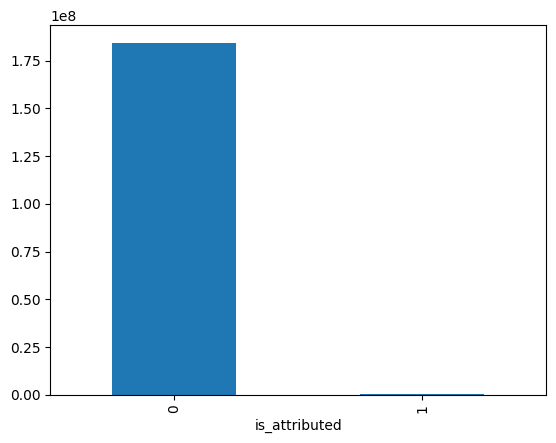

In [9]:
# 1.2. Визуализация статистик
# Изолированный анализ
counts.plot(kind='bar')

In [10]:
print(f"Начальная дата: {train.click_time.min()}, Конечная дата: {train.click_time.max()}")

Начальная дата: 2017-11-06 14:32:21, Конечная дата: 2017-11-09 16:00:00


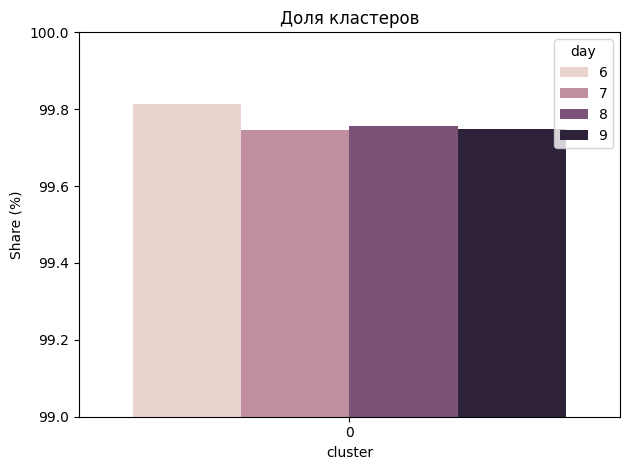

In [11]:
# Анализ во временном контексте: доли классов
# Анализ во временном контексте
train['day'] = train['click_time'].dt.day
day_cluster = train.groupby(['day', TARGET_NAME]).size()
day_cluster_pct = 100. * day_cluster / day_cluster.groupby(level='day').sum()
day_cluster_pct = day_cluster_pct.reset_index(name='share')
day_cluster_pct = day_cluster_pct[day_cluster_pct[TARGET_NAME] == 0]

sns.barplot(data=day_cluster_pct, x=TARGET_NAME, y='share', hue='day')
plt.ylim(99, 100)
plt.ylabel('Share (%)')
plt.xlabel('cluster')
plt.title('Доля кластеров')
plt.tight_layout()
plt.show()

# 2. Анализ признаков

## 2.1. Типизация признаков и их распределения

In [12]:
# Типизация признаков (числовые, категориальные, временные)
print(train.columns)

categorical = ['ip', 'app', 'device', 'os', 'channel']
time = ['click_time']

print(f"Категориальные: {categorical}")
print(f"Временные: {time}")

Index(['ip', 'app', 'device', 'os', 'channel', 'click_time', 'attributed_time',
       'is_attributed', 'day'],
      dtype='object')
Категориальные: ['ip', 'app', 'device', 'os', 'channel']
Временные: ['click_time']


### Распределения признков

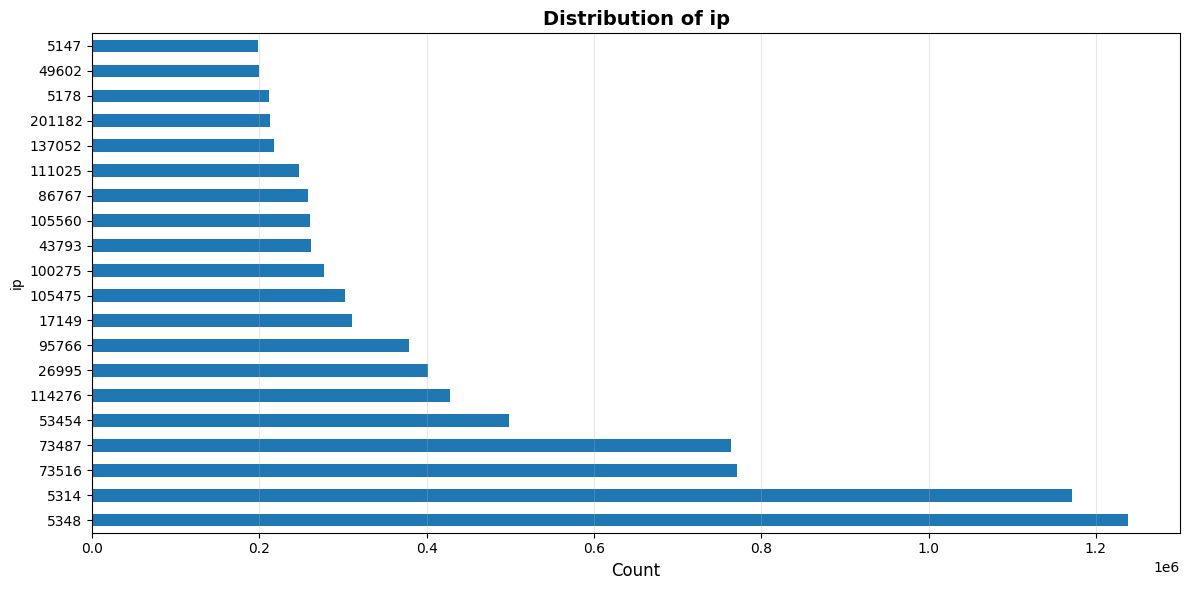

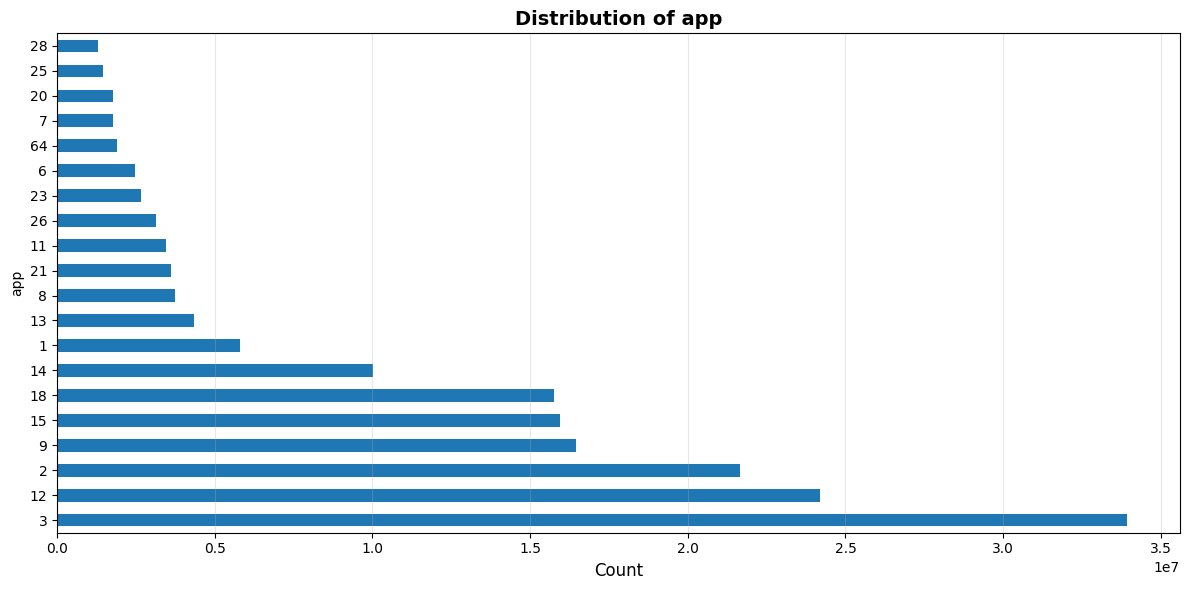

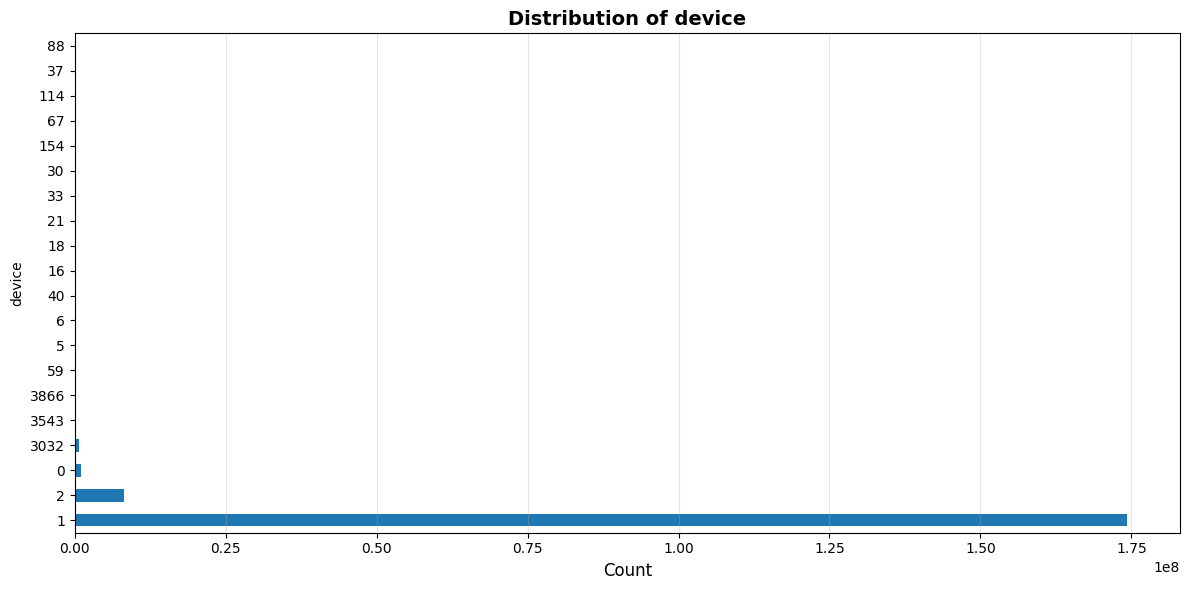

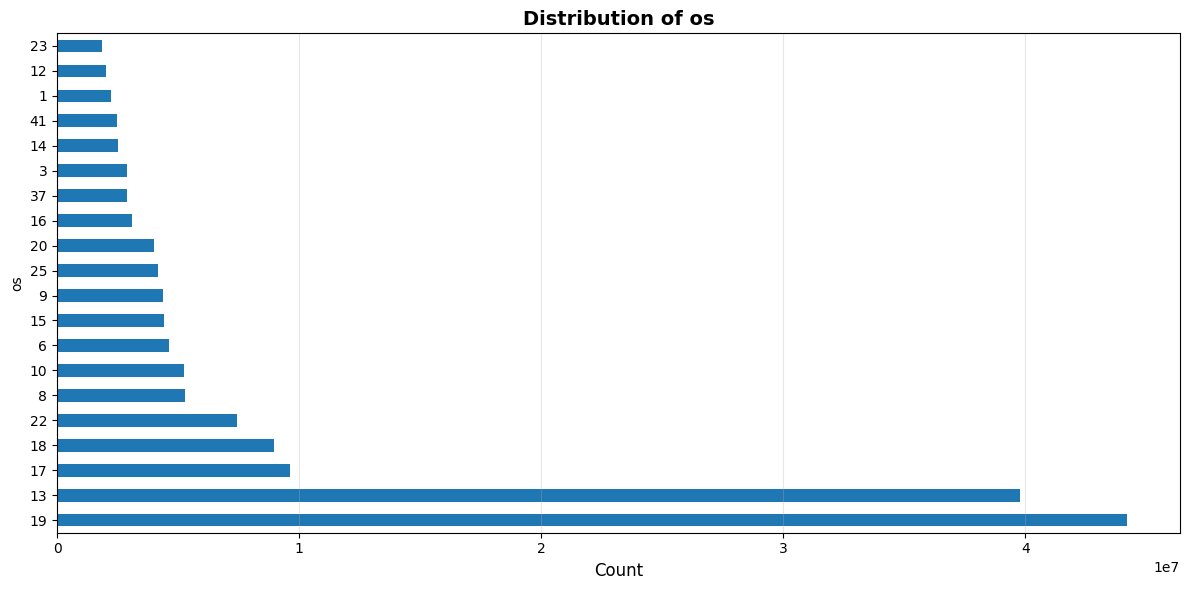

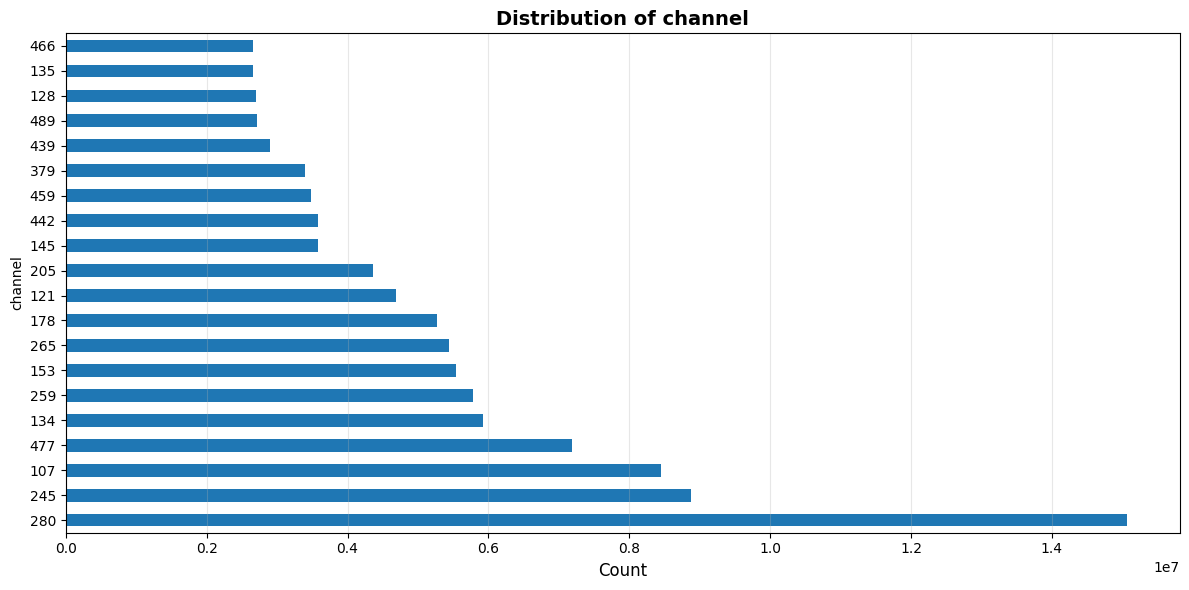

In [13]:
for col in categorical:
    fig, ax = plt.subplots(figsize=(12, 6))

    train[col].value_counts().sort_values(ascending=False)[:20].plot(kind='barh', ax=ax)
    ax.set_xlabel('Count', fontsize=12)
    ax.set_title(f'Distribution of {col}', fontsize=14, fontweight='bold')
    ax.grid(axis='x', alpha=0.3)

    plt.tight_layout()
    plt.show()

## 2.2. Выявление аномальных значений

In [14]:
print(f"Количество дублирующихся строк: {train.duplicated().sum()}") # Анализ дублирования данных
train.drop_duplicates(inplace=True)

Количество дублирующихся строк: 3619254


==============================ip==============================
Q1: 3.00
Q3: 146.00
IQR: 143.00
Нижняя граница: -211.50
Верхняя граница: 360.50

Выбросов (IQR): 53234 (19.19%)


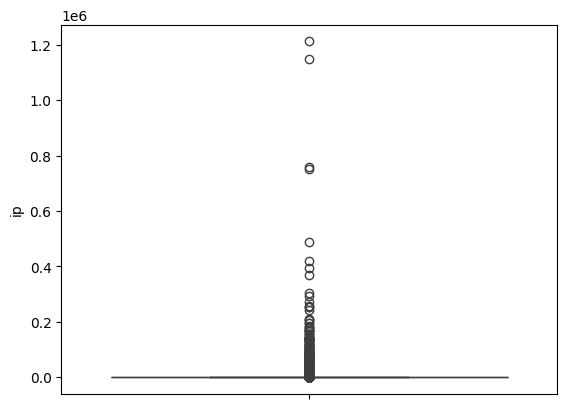

==============================app==============================
Q1: 2.00
Q3: 737.75
IQR: 735.75
Нижняя граница: -1101.62
Верхняя граница: 1841.38

Выбросов (IQR): 131 (18.56%)


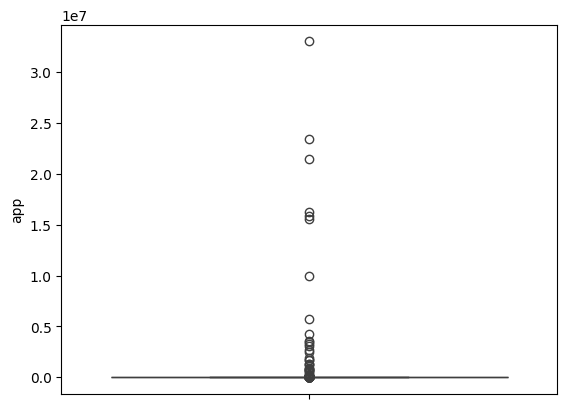

==============================device==============================
Q1: 1.00
Q3: 18.00
IQR: 17.00
Нижняя граница: -24.50
Верхняя граница: 43.50

Выбросов (IQR): 542 (15.60%)


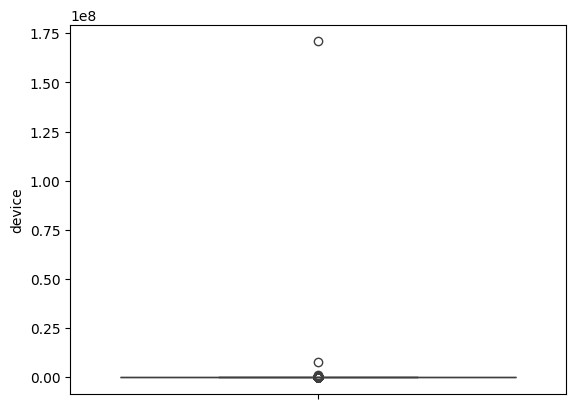

==============================os==============================
Q1: 1.00
Q3: 70.75
IQR: 69.75
Нижняя граница: -103.62
Верхняя граница: 175.38

Выбросов (IQR): 176 (22.00%)


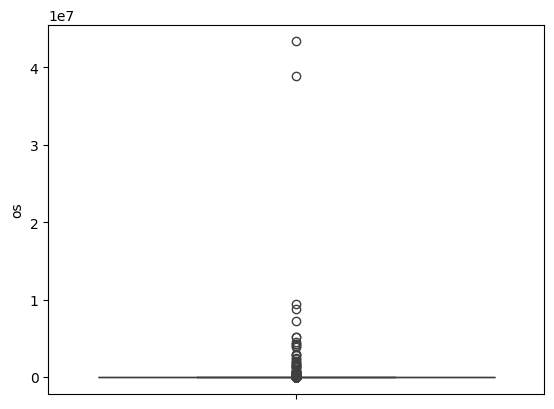

==============================channel==============================
Q1: 4227.75
Q3: 1016582.75
IQR: 1012355.00
Нижняя граница: -1514304.75
Верхняя граница: 2535115.25

Выбросов (IQR): 24 (11.88%)


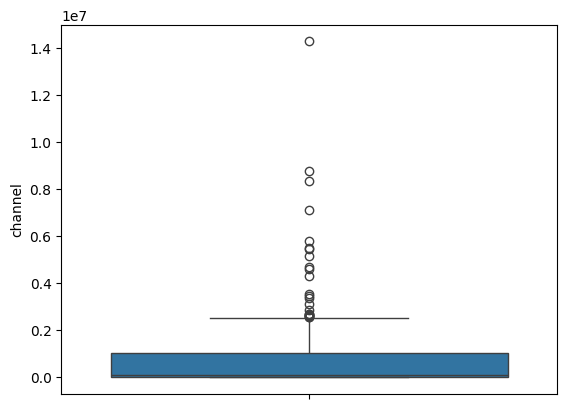

In [15]:
# Посмотрим на количество записей в разрезе по признакам

for col in categorical:
    print("="*30 + col + "="*30)
    values_per_item = train.groupby(col)[col].count()
    Q1 = values_per_item.quantile(0.25)
    Q3 = values_per_item.quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers_iqr = (values_per_item < lower_bound) | (values_per_item > upper_bound)
    print(f"Q1: {Q1:.2f}")
    print(f"Q3: {Q3:.2f}")
    print(f"IQR: {IQR:.2f}")
    print(f"Нижняя граница: {lower_bound:.2f}")
    print(f"Верхняя граница: {upper_bound:.2f}")
    print(f"\nВыбросов (IQR): {outliers_iqr.sum()} ({outliers_iqr.sum()/len(values_per_item)*100:.2f}%)")
    sns.boxplot(data=values_per_item)
    plt.show()

## 2.3. Анализ зависимостей между признаками

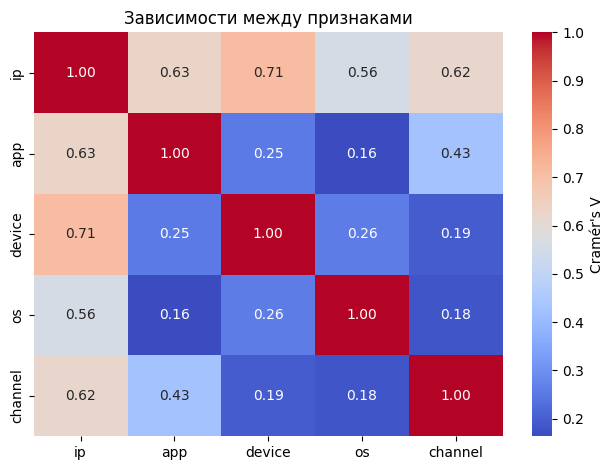

In [16]:
# 1. Cramér's V (корреляция между категориями)
from scipy.stats import chi2_contingency

def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    min_dim = min(confusion_matrix.shape) - 1
    return np.sqrt(chi2 / (n * min_dim)) if min_dim > 0 else 0

train_sample = train.sample(n=100000, random_state=42)

# Матрица корреляций
cramers_matrix = pd.DataFrame(np.ones((len(categorical), len(categorical))),
                              index=categorical, columns=categorical)
for i, col1 in enumerate(categorical):
    for j, col2 in enumerate(categorical):
        if i <= j:
            cramers_matrix.iloc[i, j] = cramers_v(train_sample[col1], train_sample[col2])
            cramers_matrix.iloc[j, i] = cramers_matrix.iloc[i, j]

# Heatmap
sns.heatmap(cramers_matrix, annot=True, fmt='.2f', cmap='coolwarm', cbar_kws={'label': "Cramér's V"})
plt.title("Зависимости между признаками")
plt.tight_layout()
plt.show()

## 2.4. Анализ пропущенных значений

In [17]:
# Анализ пропущенных значений
missing_data = []

for col in categorical + time:
    missing_count = train[col].isnull().sum()
    missing_pct = 100 * missing_count / len(train)
    missing_data.append({
        'Признак': col,
        'Пропусков': missing_count,
        'Доля (%)': f'{missing_pct:.2f}%'
    })

missing_df = pd.DataFrame(missing_data).sort_values(by='Доля (%)', ascending=False)
print(missing_df.to_string(index=False))

   Признак  Пропусков Доля (%)
        ip          0    0.00%
       app          0    0.00%
    device          0    0.00%
        os          0    0.00%
   channel          0    0.00%
click_time          0    0.00%


## 2.5. Определение важности признаков (корреляции с таргетом)

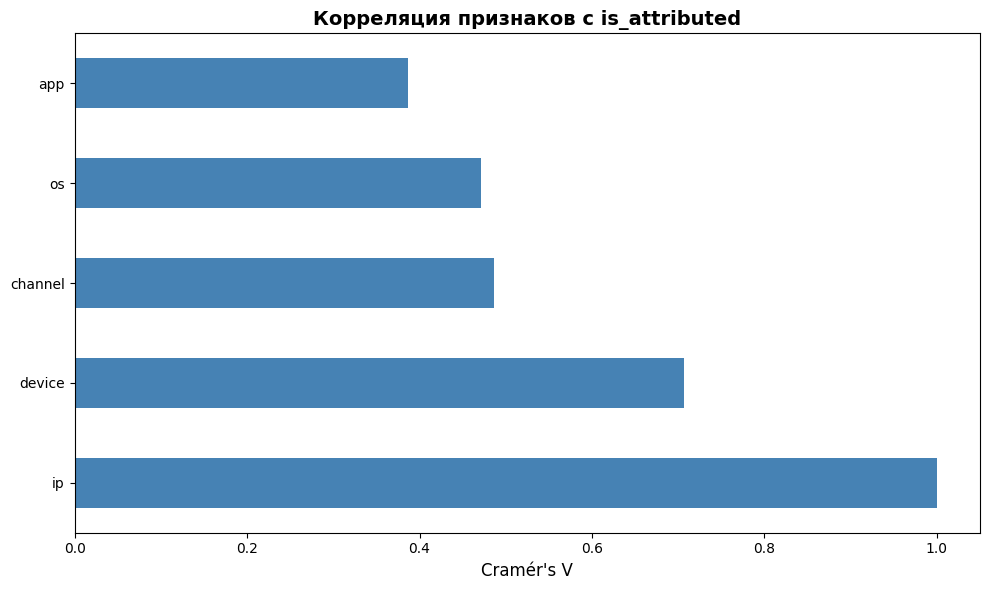

ip         1.000000
device     0.706294
channel    0.486414
os         0.470892
app        0.386736
dtype: float64


In [18]:
def cramers_v_target(df, features, target=TARGET_NAME):
    """Cramér's V между фичами и целевой переменной hotel_cluster"""
    df = df.sample(n=1000)
    correlations = {}

    for col in features:
        # Crosstab
        ct = pd.crosstab(df[col], df[target])

        # Chi-square
        chi2 = chi2_contingency(ct)[0]

        # Cramér's V
        n_samples = ct.sum().sum()
        min_dim = min(ct.shape) - 1
        v = np.sqrt(chi2 / (n_samples * min_dim)) if min_dim > 0 else 0

        correlations[col] = v

    return pd.Series(correlations).sort_values(ascending=False)

target_corr = cramers_v_target(train, categorical)

# График
fig, ax = plt.subplots(figsize=(10, 6))
target_corr.plot(kind='barh', ax=ax, color='steelblue')
ax.set_xlabel("Cramér's V", fontsize=12)
ax.set_title("Корреляция признаков с is_attributed", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print(target_corr)

## 2.6. Анализ возможных преобразований и генерации новых признаков

In [19]:
# Ботовые клики можно определить по большому числу кликов в один момент времени, поэтому посчитаем число кликов с одного ip в час и в минуту
# из click_time извлечем количество часов с первого наблюдения
# При построении фичи важно учитывать что клики по рекламе упорядочны по времени и мы не можем использовать данные из будущего
train['hours_from_start'] = np.floor((train['click_time'] - train['click_time'].min()).dt.total_seconds() / 3600).astype(int)
hour_ip_group = train.groupby(['ip', 'hours_from_start'])['ip'].count().reset_index(name='hour_ip_clicks')
hour_ip_group = hour_ip_group.sort_values(['ip', 'hours_from_start'])
for window in [1, 3, 6]:
    hour_ip_group[f'ip_clicks_last_{window}h'] = (
        hour_ip_group.groupby('ip')['hour_ip_clicks']
        .shift(1)
        .rolling(window=window, min_periods=1)
        .mean()
        .reset_index(level=0, drop=True)
    )
hour_ip_group[['ip_clicks_last_1h', 'ip_clicks_last_3h', 'ip_clicks_last_6h']] = hour_ip_group[['ip_clicks_last_1h', 'ip_clicks_last_3h', 'ip_clicks_last_6h']].fillna(0)
train = train.merge(hour_ip_group, on=['ip', 'hours_from_start'], how='left')




test['hours_from_start'] = np.floor((test['click_time'] - test['click_time'].min()).dt.total_seconds() / 3600).astype(int)
hour_ip_group = test.groupby(['ip', 'hours_from_start'])['ip'].count().reset_index(name='hour_ip_clicks')
hour_ip_group = hour_ip_group.sort_values(['ip', 'hours_from_start'])
for window in [1, 3, 6]:
    hour_ip_group[f'ip_clicks_last_{window}h'] = (
        hour_ip_group.groupby('ip')['hour_ip_clicks']
        .shift(1)
        .rolling(window=window, min_periods=1)
        .mean()
        .reset_index(level=0, drop=True)
    )
hour_ip_group[['ip_clicks_last_1h', 'ip_clicks_last_3h', 'ip_clicks_last_6h']] = hour_ip_group[['ip_clicks_last_1h', 'ip_clicks_last_3h', 'ip_clicks_last_6h']].fillna(0)
test = test.merge(hour_ip_group, on=['ip', 'hours_from_start'], how='left')

In [20]:
# Аналогичные фичи сделаем для минут
train['minutes_from_start'] = np.floor((train['click_time'] - train['click_time'].min()).dt.total_seconds() / 60).astype(int)

minute_ip_group = train.groupby(['ip', 'minutes_from_start'])['ip'].count().reset_index(name='minute_ip_clicks')
minute_ip_group = minute_ip_group.sort_values(['ip', 'minutes_from_start'])

for window in [1, 3, 5, 10, 25]:
    minute_ip_group[f'ip_clicks_last_{window}m'] = (
        minute_ip_group.groupby('ip')['minute_ip_clicks']
        .shift(1)
        .rolling(window=window, min_periods=1)
        .sum()
        .reset_index(level=0, drop=True)
    )
minute_ip_group[['ip_clicks_last_1m', 'ip_clicks_last_3m', 'ip_clicks_last_5m', 'ip_clicks_last_10m', 'ip_clicks_last_25m']] = minute_ip_group[['ip_clicks_last_1m', 'ip_clicks_last_3m', 'ip_clicks_last_5m', 'ip_clicks_last_10m', 'ip_clicks_last_25m']].fillna(0)
train = train.merge(minute_ip_group, on=['ip', 'minutes_from_start'], how='left')


test['minutes_from_start'] = np.floor((test['click_time'] - test['click_time'].min()).dt.total_seconds() / 60).astype(int)
minute_ip_group = test.groupby(['ip', 'minutes_from_start'])['ip'].count().reset_index(name='minute_ip_clicks')
minute_ip_group = minute_ip_group.sort_values(['ip', 'minutes_from_start'])

for window in [1, 3, 5, 10, 25]:
    minute_ip_group[f'ip_clicks_last_{window}m'] = (
        minute_ip_group.groupby('ip')['minute_ip_clicks']
        .shift(1)
        .rolling(window=window, min_periods=1)
        .sum()
        .reset_index(level=0, drop=True)
    )
minute_ip_group[['ip_clicks_last_1m', 'ip_clicks_last_3m', 'ip_clicks_last_5m', 'ip_clicks_last_10m', 'ip_clicks_last_25m']] = minute_ip_group[['ip_clicks_last_1m', 'ip_clicks_last_3m', 'ip_clicks_last_5m', 'ip_clicks_last_10m', 'ip_clicks_last_25m']].fillna(0)
test = test.merge(minute_ip_group, on=['ip', 'minutes_from_start'], how='left')

### Применим находки из eda

In [21]:
# lama не завершится за обозримое время на всем объеме данных,
# поэтому извлечем из train датасета sample и построим модели на нем
# так можно сделать поскольку лаговые фичи мы уже извлекли и сдвига train-test не произойдет
# дополнительно проконтроллируем это на скоре
train_ml = train.sample(frac=0.1, random_state=RANDOM_STATE)

# 3. Моделирование

## 3.1. Обоснование стратегии разделения данных (train-test split)

Исходные данные представляют из себя клики по рекламе. Наша цель определить, сделаны клики реальными людьми или ботами.
В данные присутствует последовательность. Клики упорядоченны по click_time. Также тестовые данные идут за период после обучения.

Этот факт так же учтен на шаге feature engineering, в котором мы делали только группировку только за прошедший период.

Чтобы избежать утечки данных использует time-based валидацию.
Тоесть разбиваем train датасет на train/validation в пропорции 80/20 так чтобы validation шел после test. Иначае говоря, выбираем таком click_time до которого 80% данных, а после - 20%.

Качество обученного на train решения будем оценить по отложенной 20% validation выборке.

## 3.2 LAMA бейзлайн:
- Минимум 2 различные конфигурации
- Выбор лучшего решения

In [22]:
train_ml = train_ml[['ip', 'app', 'device', 'os', 'channel', 'click_time', 'ip_clicks_last_1h', 'ip_clicks_last_3h', 'ip_clicks_last_6h', 'ip_clicks_last_1m', 'ip_clicks_last_3m', 'ip_clicks_last_5m', 'ip_clicks_last_10m', 'ip_clicks_last_25m', 'is_attributed']]
click_ids = test['click_id']
test = test[['ip', 'app', 'device', 'os', 'channel', 'ip_clicks_last_1h', 'ip_clicks_last_3h', 'ip_clicks_last_6h', 'ip_clicks_last_1m', 'ip_clicks_last_3m', 'ip_clicks_last_5m', 'ip_clicks_last_10m', 'ip_clicks_last_25m']]


In [23]:
def run_auto_ml(config):
    automl = TabularUtilizedAutoML(
        task=task,
        cpu_limit=N_THREADS,
        **config
        )
    oof_pred = automl.fit_predict(
        train_data=X_train,
        valid_data=X_val,
        roles=roles,
        verbose=0)
    val_pred = automl.predict(X_val)
    auc = roc_auc_score(X_val[TARGET_NAME], val_pred.data)
    return automl, auc

In [25]:
train_ml = train_ml.sort_values('click_time').reset_index(drop=True)

split_idx = int(len(train_ml) * (1 - VAL_SIZE))
X_train = train_ml[:split_idx]
X_val = train_ml[split_idx:]

task = Task('binary', metric='auc')
roles = {
    'target': TARGET_NAME,
    'drop': ['click_time']
    }

config1 = {
    'timeout': 500,
    'general_params': {
        'use_algos': [['lgb', 'catboost']]
        },
    'tuning_params':{
        'fit_on_holdout': True,
        'max_tuning_iter': 20,
        'max_tuning_time': 200,
        }

}

config2 = {
    'timeout': 1200,
    'tuning_params':{
        'fit_on_holdout': True,
        'max_tuning_iter': 50,
        'max_tuning_time': 900,
        }

}

automl1, auc1 = run_auto_ml(config1)
automl2, auc2 = run_auto_ml(config2)

print(f"Config 1 : AUC = {auc1:.4f}")
print(f"Config 2 : AUC = {auc2:.4f}")

result1 = pd.DataFrame({
    'click_id': click_ids,
    'is_attributed': automl1.predict(test).data.squeeze()
})
result1.to_csv('automl_1.csv', index=False)

result2 = pd.DataFrame({
    'click_id': click_ids,
    'is_attributed': automl2.predict(test).data.squeeze()
})
result2.to_csv('automl_2.csv', index=False)

INFO:lightautoml.addons.utilization.utilization:Start automl utilizator with listed constraints:
INFO:lightautoml.addons.utilization.utilization:- time: 500.00 seconds
INFO:lightautoml.addons.utilization.utilization:- CPU: 8 cores
INFO:lightautoml.addons.utilization.utilization:- memory: 16 GB

INFO:lightautoml.addons.utilization.utilization:If one preset completes earlier, next preset configuration will be started

INFO:lightautoml.addons.utilization.utilization:==================================================
INFO:lightautoml.addons.utilization.utilization:Start 0 automl preset configuration:
INFO:lightautoml.addons.utilization.utilization:conf_0_sel_type_0.yml, random state: {'reader_params': {'random_state': 42}, 'nn_params': {'random_state': 42}, 'general_params': {'return_all_predictions': False}}
INFO3:lightautoml.addons.utilization.utilization:Found general_params in kwargs, need to combine
INFO3:lightautoml.addons.utilization.utilization:Merged variant for general_params = {

Config 1 : AUC = 0.9450
Config 2 : AUC = 0.9573


In [32]:
def xgboost(df):
    N_TRIALS = 100
    TIMEOUT = 600
    df = df.sort_values('click_time').reset_index(drop=True)
    split_idx = int(len(df) * (1 - VAL_SIZE))
    X_train = df[:split_idx].drop(['is_attributed', 'click_time'], axis=1)
    y_train = df[:split_idx]['is_attributed']
    X_val = df[split_idx:].drop(['is_attributed', 'click_time'], axis=1)
    y_val = df[split_idx:]['is_attributed']
    print(f"Train: {X_train.shape}, Val: {X_val.shape}")

    def objective(trial):
        params = {
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.3, log=True),
            'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
            'subsample': trial.suggest_float('subsample', 0.5, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
            'reg_alpha': trial.suggest_float('reg_alpha', 0.001, 10.0, log=True),
            'reg_lambda': trial.suggest_float('reg_lambda', 0.001, 10.0, log=True),
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
            'objective': 'binary:logistic',
            'eval_metric': 'auc',
            'random_state': RANDOM_STATE,
            'n_jobs': -1,
            'tree_method': 'gpu_hist',
            'gpu_id': 0
        }
        model = xgb.XGBClassifier(**params, verbosity=0)
        model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)

        y_pred = model.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)

        return auc
    print("\n=== Optuna Optimization ===")
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=N_TRIALS, timeout=TIMEOUT, show_progress_bar=True)

    print(f"\nBest AUC: {study.best_value:.4f}")
    print(f"Best params: {study.best_params}")

    best_params = study.best_params
    best_params.update({
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'random_state': RANDOM_STATE,
        'n_jobs': -1,
    })

    final_model = xgb.XGBClassifier(**best_params, verbosity=0)
    final_model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)

    # Оценка
    y_pred_train = final_model.predict_proba(X_train)[:, 1]
    y_pred_val = final_model.predict_proba(X_val)[:, 1]

    auc_train = roc_auc_score(y_train, y_pred_train)
    auc_val = roc_auc_score(y_val, y_pred_val)
    return final_model, auc_val


model, auc = xgboost(train_ml.copy())
print(f"\n=== Final Results ===")
print(f"Val AUC: {auc:.4f}")

[I 2025-12-14 21:25:43,266] A new study created in memory with name: no-name-2e487ae1-27d1-474a-9ee9-2910504a6564
INFO:optuna.storages._in_memory:A new study created in memory with name: no-name-2e487ae1-27d1-474a-9ee9-2910504a6564


Train: (14502771, 13), Val: (3625693, 13)

=== Optuna Optimization ===


  0%|          | 0/100 [00:00<?, ?it/s]

INFO:optuna.study.study:Trial 0 finished with value: 0.9246551975295385 and parameters: {'max_depth': 6, 'learning_rate': 0.0052011863737684025, 'n_estimators': 320, 'subsample': 0.8068947618721173, 'colsample_bytree': 0.8745720539120954, 'reg_alpha': 0.046065160845804184, 'reg_lambda': 0.0018977841582240359, 'min_child_weight': 5}. Best is trial 0 with value: 0.9246551975295385.


[I 2025-12-14 21:25:55,796] Trial 0 finished with value: 0.9246551975295385 and parameters: {'max_depth': 6, 'learning_rate': 0.0052011863737684025, 'n_estimators': 320, 'subsample': 0.8068947618721173, 'colsample_bytree': 0.8745720539120954, 'reg_alpha': 0.046065160845804184, 'reg_lambda': 0.0018977841582240359, 'min_child_weight': 5}. Best is trial 0 with value: 0.9246551975295385.


INFO:optuna.study.study:Trial 1 finished with value: 0.9613429642724857 and parameters: {'max_depth': 3, 'learning_rate': 0.06318967180722891, 'n_estimators': 718, 'subsample': 0.8121628593164005, 'colsample_bytree': 0.8694332738030945, 'reg_alpha': 7.7329605492229945, 'reg_lambda': 0.018013460006445402, 'min_child_weight': 9}. Best is trial 1 with value: 0.9613429642724857.


[I 2025-12-14 21:26:11,261] Trial 1 finished with value: 0.9613429642724857 and parameters: {'max_depth': 3, 'learning_rate': 0.06318967180722891, 'n_estimators': 718, 'subsample': 0.8121628593164005, 'colsample_bytree': 0.8694332738030945, 'reg_alpha': 7.7329605492229945, 'reg_lambda': 0.018013460006445402, 'min_child_weight': 9}. Best is trial 1 with value: 0.9613429642724857.


INFO:optuna.study.study:Trial 2 finished with value: 0.96124552312727 and parameters: {'max_depth': 9, 'learning_rate': 0.011002779242265249, 'n_estimators': 566, 'subsample': 0.8022264151104128, 'colsample_bytree': 0.7245258894944915, 'reg_alpha': 1.0093379189478222, 'reg_lambda': 0.0452286155743167, 'min_child_weight': 4}. Best is trial 1 with value: 0.9613429642724857.


[I 2025-12-14 21:26:33,547] Trial 2 finished with value: 0.96124552312727 and parameters: {'max_depth': 9, 'learning_rate': 0.011002779242265249, 'n_estimators': 566, 'subsample': 0.8022264151104128, 'colsample_bytree': 0.7245258894944915, 'reg_alpha': 1.0093379189478222, 'reg_lambda': 0.0452286155743167, 'min_child_weight': 4}. Best is trial 1 with value: 0.9613429642724857.


INFO:optuna.study.study:Trial 3 finished with value: 0.9634231466775326 and parameters: {'max_depth': 10, 'learning_rate': 0.009040932162723588, 'n_estimators': 866, 'subsample': 0.8939235747232309, 'colsample_bytree': 0.629091574657643, 'reg_alpha': 0.7104929329638621, 'reg_lambda': 0.0012671815104428597, 'min_child_weight': 6}. Best is trial 3 with value: 0.9634231466775326.


[I 2025-12-14 21:27:07,805] Trial 3 finished with value: 0.9634231466775326 and parameters: {'max_depth': 10, 'learning_rate': 0.009040932162723588, 'n_estimators': 866, 'subsample': 0.8939235747232309, 'colsample_bytree': 0.629091574657643, 'reg_alpha': 0.7104929329638621, 'reg_lambda': 0.0012671815104428597, 'min_child_weight': 6}. Best is trial 3 with value: 0.9634231466775326.


INFO:optuna.study.study:Trial 4 finished with value: 0.946141627933116 and parameters: {'max_depth': 9, 'learning_rate': 0.0013121584711820486, 'n_estimators': 987, 'subsample': 0.5786927386715872, 'colsample_bytree': 0.5313500387705815, 'reg_alpha': 0.8223889239621304, 'reg_lambda': 1.1271063302801922, 'min_child_weight': 7}. Best is trial 3 with value: 0.9634231466775326.


[I 2025-12-14 21:27:36,887] Trial 4 finished with value: 0.946141627933116 and parameters: {'max_depth': 9, 'learning_rate': 0.0013121584711820486, 'n_estimators': 987, 'subsample': 0.5786927386715872, 'colsample_bytree': 0.5313500387705815, 'reg_alpha': 0.8223889239621304, 'reg_lambda': 1.1271063302801922, 'min_child_weight': 7}. Best is trial 3 with value: 0.9634231466775326.


INFO:optuna.study.study:Trial 5 finished with value: 0.9494754749293103 and parameters: {'max_depth': 9, 'learning_rate': 0.003722710281186481, 'n_estimators': 318, 'subsample': 0.8088592508227408, 'colsample_bytree': 0.564917220018267, 'reg_alpha': 0.0023425089601048893, 'reg_lambda': 0.43280123049968755, 'min_child_weight': 1}. Best is trial 3 with value: 0.9634231466775326.


[I 2025-12-14 21:27:53,028] Trial 5 finished with value: 0.9494754749293103 and parameters: {'max_depth': 9, 'learning_rate': 0.003722710281186481, 'n_estimators': 318, 'subsample': 0.8088592508227408, 'colsample_bytree': 0.564917220018267, 'reg_alpha': 0.0023425089601048893, 'reg_lambda': 0.43280123049968755, 'min_child_weight': 1}. Best is trial 3 with value: 0.9634231466775326.


INFO:optuna.study.study:Trial 6 finished with value: 0.9458853334219928 and parameters: {'max_depth': 8, 'learning_rate': 0.005026407355531873, 'n_estimators': 375, 'subsample': 0.5477613712584768, 'colsample_bytree': 0.9789309339645983, 'reg_alpha': 0.37213395445124464, 'reg_lambda': 0.13579105754661186, 'min_child_weight': 1}. Best is trial 3 with value: 0.9634231466775326.


[I 2025-12-14 21:28:08,139] Trial 6 finished with value: 0.9458853334219928 and parameters: {'max_depth': 8, 'learning_rate': 0.005026407355531873, 'n_estimators': 375, 'subsample': 0.5477613712584768, 'colsample_bytree': 0.9789309339645983, 'reg_alpha': 0.37213395445124464, 'reg_lambda': 0.13579105754661186, 'min_child_weight': 1}. Best is trial 3 with value: 0.9634231466775326.


INFO:optuna.study.study:Trial 7 finished with value: 0.9648288711584936 and parameters: {'max_depth': 6, 'learning_rate': 0.09352882300807927, 'n_estimators': 531, 'subsample': 0.5970306862191892, 'colsample_bytree': 0.8506075567067617, 'reg_alpha': 0.19528705326278778, 'reg_lambda': 0.40511965974868364, 'min_child_weight': 3}. Best is trial 7 with value: 0.9648288711584936.


[I 2025-12-14 21:28:25,122] Trial 7 finished with value: 0.9648288711584936 and parameters: {'max_depth': 6, 'learning_rate': 0.09352882300807927, 'n_estimators': 531, 'subsample': 0.5970306862191892, 'colsample_bytree': 0.8506075567067617, 'reg_alpha': 0.19528705326278778, 'reg_lambda': 0.40511965974868364, 'min_child_weight': 3}. Best is trial 7 with value: 0.9648288711584936.


INFO:optuna.study.study:Trial 8 finished with value: 0.9456727657996156 and parameters: {'max_depth': 5, 'learning_rate': 0.022251587517009203, 'n_estimators': 158, 'subsample': 0.8971629943168968, 'colsample_bytree': 0.5169164599321143, 'reg_alpha': 0.0017024060960645995, 'reg_lambda': 0.0016514591367828926, 'min_child_weight': 7}. Best is trial 7 with value: 0.9648288711584936.


[I 2025-12-14 21:28:35,487] Trial 8 finished with value: 0.9456727657996156 and parameters: {'max_depth': 5, 'learning_rate': 0.022251587517009203, 'n_estimators': 158, 'subsample': 0.8971629943168968, 'colsample_bytree': 0.5169164599321143, 'reg_alpha': 0.0017024060960645995, 'reg_lambda': 0.0016514591367828926, 'min_child_weight': 7}. Best is trial 7 with value: 0.9648288711584936.


INFO:optuna.study.study:Trial 9 finished with value: 0.9651476516371631 and parameters: {'max_depth': 6, 'learning_rate': 0.04334663213878098, 'n_estimators': 799, 'subsample': 0.9068815139313438, 'colsample_bytree': 0.5624681408160657, 'reg_alpha': 0.3294542596842619, 'reg_lambda': 0.2532606053508079, 'min_child_weight': 6}. Best is trial 9 with value: 0.9651476516371631.


[I 2025-12-14 21:28:56,411] Trial 9 finished with value: 0.9651476516371631 and parameters: {'max_depth': 6, 'learning_rate': 0.04334663213878098, 'n_estimators': 799, 'subsample': 0.9068815139313438, 'colsample_bytree': 0.5624681408160657, 'reg_alpha': 0.3294542596842619, 'reg_lambda': 0.2532606053508079, 'min_child_weight': 6}. Best is trial 9 with value: 0.9651476516371631.


INFO:optuna.study.study:Trial 10 finished with value: 0.9650791099329261 and parameters: {'max_depth': 4, 'learning_rate': 0.19447840960243787, 'n_estimators': 723, 'subsample': 0.9572307748463247, 'colsample_bytree': 0.6809373663949166, 'reg_alpha': 0.024358013260601215, 'reg_lambda': 8.733466860024368, 'min_child_weight': 10}. Best is trial 9 with value: 0.9651476516371631.


[I 2025-12-14 21:29:13,130] Trial 10 finished with value: 0.9650791099329261 and parameters: {'max_depth': 4, 'learning_rate': 0.19447840960243787, 'n_estimators': 723, 'subsample': 0.9572307748463247, 'colsample_bytree': 0.6809373663949166, 'reg_alpha': 0.024358013260601215, 'reg_lambda': 8.733466860024368, 'min_child_weight': 10}. Best is trial 9 with value: 0.9651476516371631.


INFO:optuna.study.study:Trial 11 finished with value: 0.9647186424915709 and parameters: {'max_depth': 4, 'learning_rate': 0.18465725987072082, 'n_estimators': 761, 'subsample': 0.9486564296610636, 'colsample_bytree': 0.6650299291631018, 'reg_alpha': 0.022087484879122495, 'reg_lambda': 8.684753348813189, 'min_child_weight': 10}. Best is trial 9 with value: 0.9651476516371631.


[I 2025-12-14 21:29:30,173] Trial 11 finished with value: 0.9647186424915709 and parameters: {'max_depth': 4, 'learning_rate': 0.18465725987072082, 'n_estimators': 761, 'subsample': 0.9486564296610636, 'colsample_bytree': 0.6650299291631018, 'reg_alpha': 0.022087484879122495, 'reg_lambda': 8.684753348813189, 'min_child_weight': 10}. Best is trial 9 with value: 0.9651476516371631.


INFO:optuna.study.study:Trial 12 finished with value: 0.9617052361343564 and parameters: {'max_depth': 4, 'learning_rate': 0.03936830775165218, 'n_estimators': 648, 'subsample': 0.9856358997816446, 'colsample_bytree': 0.6289455465576533, 'reg_alpha': 0.01004082764490915, 'reg_lambda': 7.438287556886745, 'min_child_weight': 9}. Best is trial 9 with value: 0.9651476516371631.


[I 2025-12-14 21:29:46,206] Trial 12 finished with value: 0.9617052361343564 and parameters: {'max_depth': 4, 'learning_rate': 0.03936830775165218, 'n_estimators': 648, 'subsample': 0.9856358997816446, 'colsample_bytree': 0.6289455465576533, 'reg_alpha': 0.01004082764490915, 'reg_lambda': 7.438287556886745, 'min_child_weight': 9}. Best is trial 9 with value: 0.9651476516371631.


INFO:optuna.study.study:Trial 13 finished with value: 0.9591883534531044 and parameters: {'max_depth': 7, 'learning_rate': 0.26761652369981237, 'n_estimators': 902, 'subsample': 0.6967819185483305, 'colsample_bytree': 0.7436686250626903, 'reg_alpha': 0.09053158193600873, 'reg_lambda': 2.1764746164517224, 'min_child_weight': 8}. Best is trial 9 with value: 0.9651476516371631.


[I 2025-12-14 21:30:11,020] Trial 13 finished with value: 0.9591883534531044 and parameters: {'max_depth': 7, 'learning_rate': 0.26761652369981237, 'n_estimators': 902, 'subsample': 0.6967819185483305, 'colsample_bytree': 0.7436686250626903, 'reg_alpha': 0.09053158193600873, 'reg_lambda': 2.1764746164517224, 'min_child_weight': 8}. Best is trial 9 with value: 0.9651476516371631.


INFO:optuna.study.study:Trial 14 finished with value: 0.9652554908919729 and parameters: {'max_depth': 5, 'learning_rate': 0.0819748179235838, 'n_estimators': 822, 'subsample': 0.90511084177527, 'colsample_bytree': 0.5918332131490867, 'reg_alpha': 0.008425180953447827, 'reg_lambda': 0.011836634235932748, 'min_child_weight': 10}. Best is trial 14 with value: 0.9652554908919729.


[I 2025-12-14 21:30:30,764] Trial 14 finished with value: 0.9652554908919729 and parameters: {'max_depth': 5, 'learning_rate': 0.0819748179235838, 'n_estimators': 822, 'subsample': 0.90511084177527, 'colsample_bytree': 0.5918332131490867, 'reg_alpha': 0.008425180953447827, 'reg_lambda': 0.011836634235932748, 'min_child_weight': 10}. Best is trial 14 with value: 0.9652554908919729.


INFO:optuna.study.study:Trial 15 finished with value: 0.9653024641358807 and parameters: {'max_depth': 7, 'learning_rate': 0.031432079802357855, 'n_estimators': 855, 'subsample': 0.7046261968619761, 'colsample_bytree': 0.5907901029748609, 'reg_alpha': 0.00580823133796375, 'reg_lambda': 0.010090918014421984, 'min_child_weight': 3}. Best is trial 15 with value: 0.9653024641358807.


[I 2025-12-14 21:30:54,870] Trial 15 finished with value: 0.9653024641358807 and parameters: {'max_depth': 7, 'learning_rate': 0.031432079802357855, 'n_estimators': 855, 'subsample': 0.7046261968619761, 'colsample_bytree': 0.5907901029748609, 'reg_alpha': 0.00580823133796375, 'reg_lambda': 0.010090918014421984, 'min_child_weight': 3}. Best is trial 15 with value: 0.9653024641358807.


INFO:optuna.study.study:Trial 16 finished with value: 0.9651409983443232 and parameters: {'max_depth': 7, 'learning_rate': 0.02380664872826574, 'n_estimators': 995, 'subsample': 0.6789364416264, 'colsample_bytree': 0.6034855680398572, 'reg_alpha': 0.004759603312258405, 'reg_lambda': 0.011219163324857612, 'min_child_weight': 3}. Best is trial 15 with value: 0.9653024641358807.


[I 2025-12-14 21:31:21,577] Trial 16 finished with value: 0.9651409983443232 and parameters: {'max_depth': 7, 'learning_rate': 0.02380664872826574, 'n_estimators': 995, 'subsample': 0.6789364416264, 'colsample_bytree': 0.6034855680398572, 'reg_alpha': 0.004759603312258405, 'reg_lambda': 0.011219163324857612, 'min_child_weight': 3}. Best is trial 15 with value: 0.9653024641358807.


INFO:optuna.study.study:Trial 17 finished with value: 0.9652554775584588 and parameters: {'max_depth': 5, 'learning_rate': 0.10047473353548426, 'n_estimators': 855, 'subsample': 0.7158499795746196, 'colsample_bytree': 0.7941650508884701, 'reg_alpha': 0.006852307359715172, 'reg_lambda': 0.006428083129426276, 'min_child_weight': 3}. Best is trial 15 with value: 0.9653024641358807.


[I 2025-12-14 21:31:41,859] Trial 17 finished with value: 0.9652554775584588 and parameters: {'max_depth': 5, 'learning_rate': 0.10047473353548426, 'n_estimators': 855, 'subsample': 0.7158499795746196, 'colsample_bytree': 0.7941650508884701, 'reg_alpha': 0.006852307359715172, 'reg_lambda': 0.006428083129426276, 'min_child_weight': 3}. Best is trial 15 with value: 0.9653024641358807.


INFO:optuna.study.study:Trial 18 finished with value: 0.9637659851533213 and parameters: {'max_depth': 8, 'learning_rate': 0.11107262223382491, 'n_estimators': 618, 'subsample': 0.7604539069115922, 'colsample_bytree': 0.5020511216012319, 'reg_alpha': 0.0010558660390700512, 'reg_lambda': 0.03476114259476946, 'min_child_weight': 2}. Best is trial 15 with value: 0.9653024641358807.


[I 2025-12-14 21:32:03,373] Trial 18 finished with value: 0.9637659851533213 and parameters: {'max_depth': 8, 'learning_rate': 0.11107262223382491, 'n_estimators': 618, 'subsample': 0.7604539069115922, 'colsample_bytree': 0.5020511216012319, 'reg_alpha': 0.0010558660390700512, 'reg_lambda': 0.03476114259476946, 'min_child_weight': 2}. Best is trial 15 with value: 0.9653024641358807.


INFO:optuna.study.study:Trial 19 finished with value: 0.9620398505742378 and parameters: {'max_depth': 5, 'learning_rate': 0.035822072985009, 'n_estimators': 461, 'subsample': 0.6682899991634234, 'colsample_bytree': 0.6831494508422796, 'reg_alpha': 0.015249696373411871, 'reg_lambda': 0.004872341047159256, 'min_child_weight': 5}. Best is trial 15 with value: 0.9653024641358807.


[I 2025-12-14 21:32:18,167] Trial 19 finished with value: 0.9620398505742378 and parameters: {'max_depth': 5, 'learning_rate': 0.035822072985009, 'n_estimators': 461, 'subsample': 0.6682899991634234, 'colsample_bytree': 0.6831494508422796, 'reg_alpha': 0.015249696373411871, 'reg_lambda': 0.004872341047159256, 'min_child_weight': 5}. Best is trial 15 with value: 0.9653024641358807.


INFO:optuna.study.study:Trial 20 finished with value: 0.9638119870093942 and parameters: {'max_depth': 7, 'learning_rate': 0.015074881653171602, 'n_estimators': 910, 'subsample': 0.625290493223957, 'colsample_bytree': 0.5843453007175952, 'reg_alpha': 0.00324690743626793, 'reg_lambda': 0.09375363344722455, 'min_child_weight': 4}. Best is trial 15 with value: 0.9653024641358807.


[I 2025-12-14 21:32:43,807] Trial 20 finished with value: 0.9638119870093942 and parameters: {'max_depth': 7, 'learning_rate': 0.015074881653171602, 'n_estimators': 910, 'subsample': 0.625290493223957, 'colsample_bytree': 0.5843453007175952, 'reg_alpha': 0.00324690743626793, 'reg_lambda': 0.09375363344722455, 'min_child_weight': 4}. Best is trial 15 with value: 0.9653024641358807.


INFO:optuna.study.study:Trial 21 finished with value: 0.9651736016004128 and parameters: {'max_depth': 5, 'learning_rate': 0.09378691529634402, 'n_estimators': 806, 'subsample': 0.7198225676770528, 'colsample_bytree': 0.787730396644581, 'reg_alpha': 0.004342685852628221, 'reg_lambda': 0.006137756530469999, 'min_child_weight': 3}. Best is trial 15 with value: 0.9653024641358807.


[I 2025-12-14 21:33:03,240] Trial 21 finished with value: 0.9651736016004128 and parameters: {'max_depth': 5, 'learning_rate': 0.09378691529634402, 'n_estimators': 806, 'subsample': 0.7198225676770528, 'colsample_bytree': 0.787730396644581, 'reg_alpha': 0.004342685852628221, 'reg_lambda': 0.006137756530469999, 'min_child_weight': 3}. Best is trial 15 with value: 0.9653024641358807.


INFO:optuna.study.study:Trial 22 finished with value: 0.9628306538095432 and parameters: {'max_depth': 3, 'learning_rate': 0.06850851507571343, 'n_estimators': 868, 'subsample': 0.7497021228960042, 'colsample_bytree': 0.8165927867985375, 'reg_alpha': 0.007477248273773794, 'reg_lambda': 0.004202270097390299, 'min_child_weight': 2}. Best is trial 15 with value: 0.9653024641358807.


[I 2025-12-14 21:33:20,249] Trial 22 finished with value: 0.9628306538095432 and parameters: {'max_depth': 3, 'learning_rate': 0.06850851507571343, 'n_estimators': 868, 'subsample': 0.7497021228960042, 'colsample_bytree': 0.8165927867985375, 'reg_alpha': 0.007477248273773794, 'reg_lambda': 0.004202270097390299, 'min_child_weight': 2}. Best is trial 15 with value: 0.9653024641358807.


INFO:optuna.study.study:Trial 23 finished with value: 0.9640932720511187 and parameters: {'max_depth': 5, 'learning_rate': 0.1647191257083126, 'n_estimators': 688, 'subsample': 0.5059123740943673, 'colsample_bytree': 0.9272709922557121, 'reg_alpha': 0.046515640973113975, 'reg_lambda': 0.011932590008449104, 'min_child_weight': 4}. Best is trial 15 with value: 0.9653024641358807.


[I 2025-12-14 21:33:38,067] Trial 23 finished with value: 0.9640932720511187 and parameters: {'max_depth': 5, 'learning_rate': 0.1647191257083126, 'n_estimators': 688, 'subsample': 0.5059123740943673, 'colsample_bytree': 0.9272709922557121, 'reg_alpha': 0.046515640973113975, 'reg_lambda': 0.011932590008449104, 'min_child_weight': 4}. Best is trial 15 with value: 0.9653024641358807.


INFO:optuna.study.study:Trial 24 finished with value: 0.9657967736505639 and parameters: {'max_depth': 6, 'learning_rate': 0.051408854914442095, 'n_estimators': 824, 'subsample': 0.8524128733208557, 'colsample_bytree': 0.781040903545212, 'reg_alpha': 0.008566392268834712, 'reg_lambda': 0.028220573295095624, 'min_child_weight': 2}. Best is trial 24 with value: 0.9657967736505639.


[I 2025-12-14 21:33:59,481] Trial 24 finished with value: 0.9657967736505639 and parameters: {'max_depth': 6, 'learning_rate': 0.051408854914442095, 'n_estimators': 824, 'subsample': 0.8524128733208557, 'colsample_bytree': 0.781040903545212, 'reg_alpha': 0.008566392268834712, 'reg_lambda': 0.028220573295095624, 'min_child_weight': 2}. Best is trial 24 with value: 0.9657967736505639.


INFO:optuna.study.study:Trial 25 finished with value: 0.9654757695509272 and parameters: {'max_depth': 8, 'learning_rate': 0.028792435910450876, 'n_estimators': 945, 'subsample': 0.86536415591901, 'colsample_bytree': 0.722604081751181, 'reg_alpha': 0.001034747151673072, 'reg_lambda': 0.03233481407972579, 'min_child_weight': 2}. Best is trial 24 with value: 0.9657967736505639.


[I 2025-12-14 21:34:28,280] Trial 25 finished with value: 0.9654757695509272 and parameters: {'max_depth': 8, 'learning_rate': 0.028792435910450876, 'n_estimators': 945, 'subsample': 0.86536415591901, 'colsample_bytree': 0.722604081751181, 'reg_alpha': 0.001034747151673072, 'reg_lambda': 0.03233481407972579, 'min_child_weight': 2}. Best is trial 24 with value: 0.9657967736505639.


INFO:optuna.study.study:Trial 26 finished with value: 0.9656764212484559 and parameters: {'max_depth': 8, 'learning_rate': 0.02857143760024479, 'n_estimators': 940, 'subsample': 0.86352466056143, 'colsample_bytree': 0.718549793431014, 'reg_alpha': 0.0010259037077045723, 'reg_lambda': 0.037392534697046474, 'min_child_weight': 2}. Best is trial 24 with value: 0.9657967736505639.


[I 2025-12-14 21:34:57,006] Trial 26 finished with value: 0.9656764212484559 and parameters: {'max_depth': 8, 'learning_rate': 0.02857143760024479, 'n_estimators': 940, 'subsample': 0.86352466056143, 'colsample_bytree': 0.718549793431014, 'reg_alpha': 0.0010259037077045723, 'reg_lambda': 0.037392534697046474, 'min_child_weight': 2}. Best is trial 24 with value: 0.9657967736505639.


INFO:optuna.study.study:Trial 27 finished with value: 0.9652832780219183 and parameters: {'max_depth': 8, 'learning_rate': 0.016673269066336455, 'n_estimators': 939, 'subsample': 0.8574597859848706, 'colsample_bytree': 0.7152940427309982, 'reg_alpha': 0.0013816877387457188, 'reg_lambda': 0.03697220642233671, 'min_child_weight': 2}. Best is trial 24 with value: 0.9657967736505639.


[I 2025-12-14 21:35:26,516] Trial 27 finished with value: 0.9652832780219183 and parameters: {'max_depth': 8, 'learning_rate': 0.016673269066336455, 'n_estimators': 939, 'subsample': 0.8574597859848706, 'colsample_bytree': 0.7152940427309982, 'reg_alpha': 0.0013816877387457188, 'reg_lambda': 0.03697220642233671, 'min_child_weight': 2}. Best is trial 24 with value: 0.9657967736505639.


INFO:optuna.study.study:Trial 28 finished with value: 0.9638062944985147 and parameters: {'max_depth': 10, 'learning_rate': 0.046242726814822374, 'n_estimators': 954, 'subsample': 0.8569827116533811, 'colsample_bytree': 0.7823442949387944, 'reg_alpha': 0.0023781561487715404, 'reg_lambda': 0.0676907274911787, 'min_child_weight': 1}. Best is trial 24 with value: 0.9657967736505639.


[I 2025-12-14 21:36:02,920] Trial 28 finished with value: 0.9638062944985147 and parameters: {'max_depth': 10, 'learning_rate': 0.046242726814822374, 'n_estimators': 954, 'subsample': 0.8569827116533811, 'colsample_bytree': 0.7823442949387944, 'reg_alpha': 0.0023781561487715404, 'reg_lambda': 0.0676907274911787, 'min_child_weight': 1}. Best is trial 24 with value: 0.9657967736505639.

Best AUC: 0.9658
Best params: {'max_depth': 6, 'learning_rate': 0.051408854914442095, 'n_estimators': 824, 'subsample': 0.8524128733208557, 'colsample_bytree': 0.781040903545212, 'reg_alpha': 0.008566392268834712, 'reg_lambda': 0.028220573295095624, 'min_child_weight': 2}

=== Final Results ===
Val AUC: 0.9658


In [33]:
result_xgb = pd.DataFrame({
    'click_id': click_ids,
    'is_attributed': model.predict_proba(test)[:, 1]
})

In [34]:
result_xgb.to_csv('result_xgb.csv', index=False)